# Sleep Apena

In [1]:
import os                           
import numpy as np                   
import pandas as pd                 
import matplotlib.pyplot as plt      
import cv2                           
from tqdm import tqdm     

# 資料集載入、再觀察與處理

In [2]:
train_csv = pd.read_csv("sleep_data_v2/train.csv", index_col=False)
test_csv = pd.read_csv("sleep_data_v2/test.csv", index_col=False)

In [3]:
train_path = "./sleep_data_v2/Mel_train"  # 指定訓練集的讀檔路徑
train_data=[]                                                      # 先宣告一個空的 list 承接檔案
for eachfile in train_csv["Number"]:                              # 用 for 迴圈將檔案名稱一個個唱名
    image = cv2.imread(os.path.join(train_path, eachfile+".png"))  # 被唱到名的檔案就會和訓練集路徑用 os.path.join 結合
                                                                   # 用 cv2.imread 將檔案開啟
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                 # 由於 cv2 開檔讀進來的是 BGR 所以我們將其轉成 RGB
    train_data.append(image)                                       # 將開啟的檔案放到 train_data 中

In [4]:
test_path = "./sleep_data_v2/Mel_test"
test_data=[]
for eachfile in test_csv["Number"]:
    image = cv2.imread(os.path.join(test_path, eachfile+".png"))    
    #print(eachfile)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_data.append(image)

In [5]:
sleep_type = {0:"Normal", 1:"Sick"}

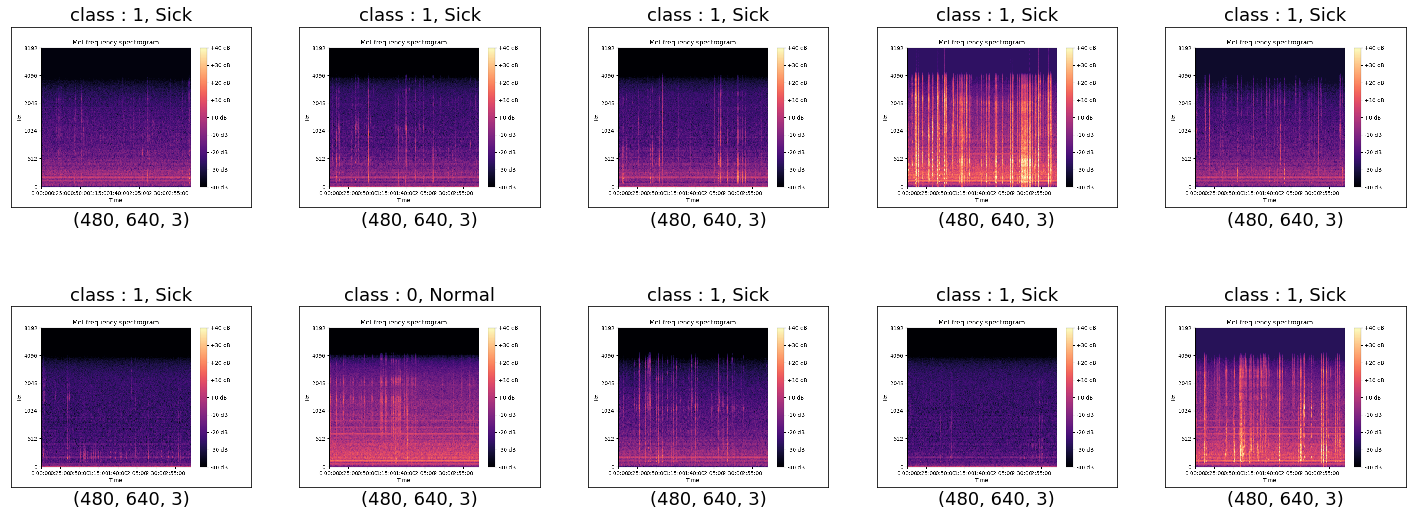

In [6]:
plt.figure(figsize=(25,30))                                        # 避免圖畫太小，用 figsize 來調控一下大小
for i in range(10):
    ax = plt.subplot(6, 5, i+1)                                    # 依序呼叫每個畫圖位置
    #plt.title("class : "+str(train_csv["diagnosis"][i] )+", "+str(diabetes_type[train_csv["diagnosis"][i]]), 
    plt.title("class : "+str(train_csv["Label"][i] )+", "+str(sleep_type[train_csv["Label"][i]]), 
               fontsize=18)                                        # 宣告每張圖的 title，此處放入對應類別
    plt.xticks([])                                                 # 避免出現不必要邊框，所以宣告 x 軸上不用貼刻度
    plt.yticks([])
    ax.set_xlabel(test_data[i].shape,fontsize=18) 
    ax.imshow(train_data[i])                                       # 將指定的影像放入呼叫的畫圖位置

In [7]:
from utils.image_processing_v2 import my_processing
# my_processing(
#                  dataset,     # 放入開完檔案的影像進此函述做前處理 
#                  outsize,     # output 時的 image size
#                  pre_type     # 希望做什麼樣的特徵強化，共有["ori", "his", "cla", "gau"]四種可以填入
#                  )

In [8]:
pre_train = my_processing(dataset = train_data, outsize=456, pre_type="his")
pre_test  = my_processing(dataset = test_data, outsize=456, pre_type="his")

# outsize 設定 456 是為了放入底下模型所指定的 size
print(train_data[0].shape)
print(pre_train[0].shape)
del train_data
del test_data

100%|██████████| 20/20 [00:00<00:00, 419.63it/s]

(480, 640, 3)
(456, 456, 3)


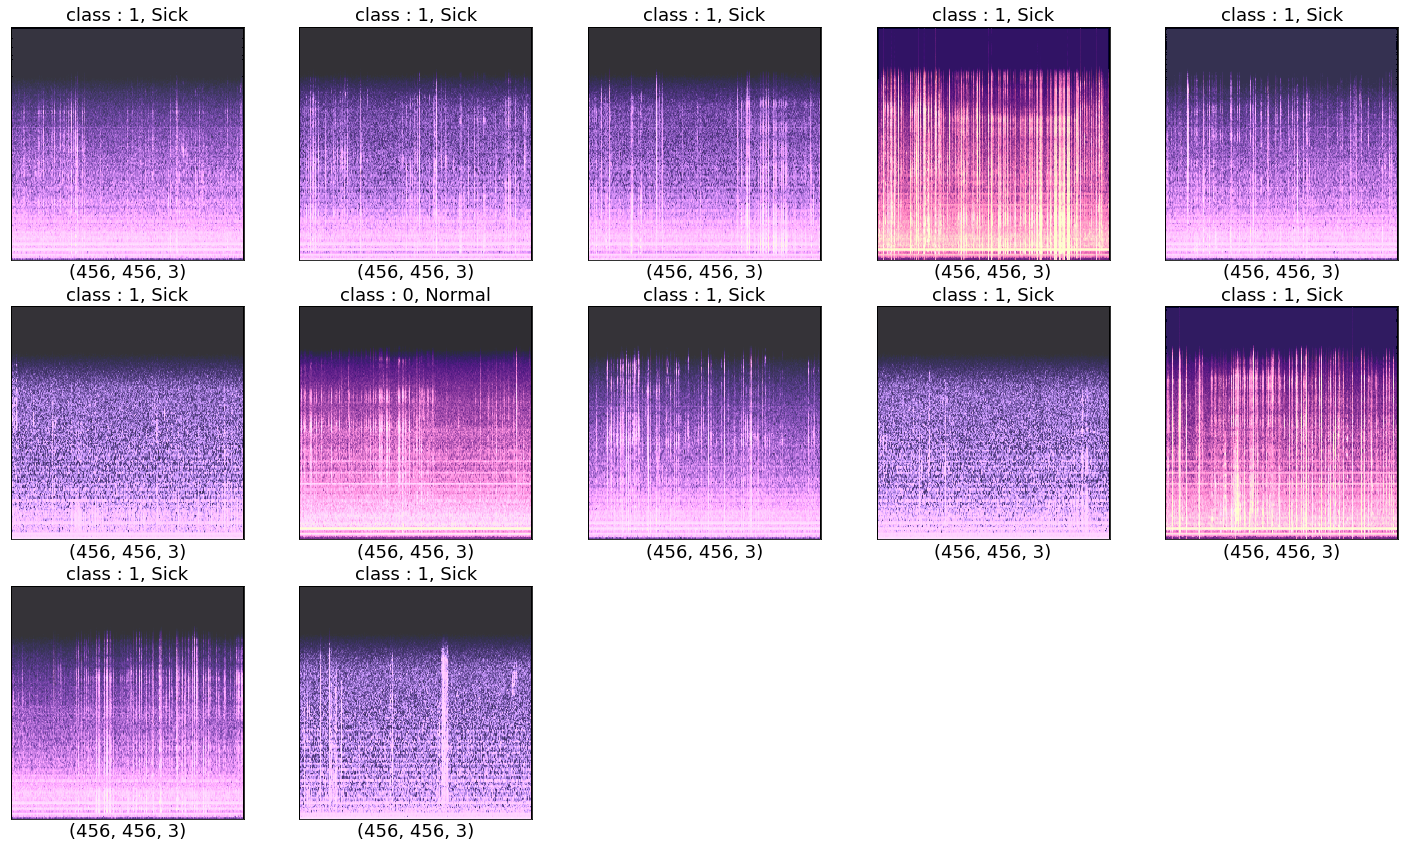

In [9]:
plt.figure(figsize=(25,30))                                        # 避免圖畫太小，用 figsize 來調控一下大小
for i in range(12):
    ax = plt.subplot(6, 5, i+1)                                    # 依序呼叫每個畫圖位置
    #plt.title("class : "+str(train_csv["diagnosis"][i] )+", "+str(diabetes_type[train_csv["diagnosis"][i]]), 
    plt.title("class : "+str(train_csv["Label"][i] )+", "+str(sleep_type[train_csv["Label"][i]]), 
               fontsize=18)                                        # 宣告每張圖的 title，此處放入對應類別
    plt.xticks([])                                                 # 避免出現不必要邊框，所以宣告 x 軸上不用貼刻度
    plt.yticks([])
    ax.set_xlabel(pre_train[i].shape, fontsize=18)
    ax.imshow(pre_train[i])                                       # 將指定的影像放入呼叫的畫圖位置

### Train_Test_Split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_valid, Y_train, Y_valid = train_test_split( pre_train, 
                                                       train_csv['Label'].values,
                                                       test_size=0.1, 
                                                       random_state=10,
                                                       stratify= train_csv['Label'].values)

In [12]:
print(Y_valid)

[1 1 1 1 1 0 1 1 1 1 1 0 1 1]


# 如何改善預測成效?
## 1. 資料方面: 增加資料量
## 2. 模型方面: 調參、改模型結構
## 3. 訓練方面: Optimizer, loss function, transfer learning

### 朝進化方向邁大步，讓我們來試試第一 + 第二種方法!

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import (Input, Dense, GlobalAveragePooling2D)
from keras.optimizers import SGD, Adam
#from efficientnet import EfficientNetB5, preprocess_input
#from efficientnet.keras import EfficientNetB5, preprocess_input
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [14]:
X_train = np.array([preprocess_input(image) for image in X_train])
X_valid = np.array([preprocess_input(image) for image in X_valid])
test_pred  = np.array([preprocess_input(image) for image in pre_test])

### Imbalance Data

[Notice] 底下兩者做其一即可，兩者多做很可能使得模型會壞掉，底下兩者做法相近，但效果不同，各有優點

(1) 計算原示資料類別比例之反比，就是說對應到的 label 資料量少的做模型更新時，權重比重較大，反之，資料量多的權重較小

In [15]:
# from sklearn.utils import class_weight
# classweight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
# classweights = { 0: classweight[0], 1: classweight[1] }

(2) 對類別取一個比例，依照比例去增加其對應的資料之資料量，一般我們直接以複製資料做為增加的方式 (此例中我們選此法)<br>
![Imgur](https://i.imgur.com/LbxlfS3.jpg?1)

In [16]:
X_train_prod = X_train.copy()
Y_train_prod = Y_train.copy()

task = {0:9,1:2}
for i in range(2):
    tmp_x = X_train[Y_train==task[i]].copy()
    tmp_y = Y_train[Y_train==task[i]].copy()
    for j in range(task[i]):
        X_train_prod = np.concatenate([X_train_prod, tmp_x])
        Y_train_prod = np.concatenate([Y_train_prod, tmp_y])

### Data Augmentation  資料增強

In [17]:
datagen = ImageDataGenerator(
                                width_shift_range = 0.0,     # 水平平移
                                height_shift_range = 0.0,    # 垂直平移
                                rotation_range = 0,        # 0-180 任一角度旋轉
                                horizontal_flip = True,      # 任意水平翻轉
                                vertical_flip = True,        # 任意垂直翻轉
                                fill_mode = "constant",      # 在旋轉或平移時，有空隙發生，則空隙補常數
                                cval = 0                     # 設定常數值為 0
                             )

In [18]:
base_model = VGG16(weights='imagenet',include_top=False)

pool = GlobalAveragePooling2D()(base_model.output) 

output = Dense(2, activation='softmax')(pool)

model = Model(inputs = base_model.input, outputs = output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
#from keras.utils import plot_model
#plot_model(base_model, to_file='./outputs/Inception_model.png')    # 畫畫模型圖

In [20]:
base_model.trainable = False
learning_rate = 1e-4
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

### 開始訓練

In [21]:
batch_sizes = 4
num_epoch = 50
step_size_train = len(X_train)//batch_sizes
model_history = model.fit_generator(
                                    datagen.flow(X_train, np.eye(2)[Y_train], batch_size=batch_sizes),
                                    steps_per_epoch = step_size_train,
                                    validation_data = (X_valid, np.eye(2)[Y_valid]),
                                    #class_weight = classweights,
                                    epochs=num_epoch, verbose=1,
                                    )

Epoch 1/50
30/30 [==============================] - 154s 5s/step - loss: 0.9774 - accuracy: 0.7583 - val_loss: 0.3968 - val_accuracy: 0.8571
Epoch 2/50
30/30 [==============================] - 150s 5s/step - loss: 1.0964 - accuracy: 0.8583 - val_loss: 0.4186 - val_accuracy: 0.8571
Epoch 3/50
30/30 [==============================] - 150s 5s/step - loss: 0.4567 - accuracy: 0.8583 - val_loss: 0.4178 - val_accuracy: 0.8571
Epoch 4/50
30/30 [==============================] - 150s 5s/step - loss: 0.4155 - accuracy: 0.8583 - val_loss: 0.3932 - val_accuracy: 0.8571
Epoch 5/50
30/30 [==============================] - 150s 5s/step - loss: 0.3908 - accuracy: 0.8583 - val_loss: 0.3486 - val_accuracy: 0.8571
Epoch 6/50
30/30 [==============================] - 149s 5s/step - loss: 0.3682 - accuracy: 0.8583 - val_loss: 0.4958 - val_accuracy: 0.8571
Epoch 7/50
30/30 [==============================] - 150s 5s/step - loss: 0.4771 - accuracy: 0.8583 - val_loss: 0.4610 - val_accuracy: 0.8571
Epoch 8/50
30

In [ ]:
print(hi)

### 繪出訓練結果

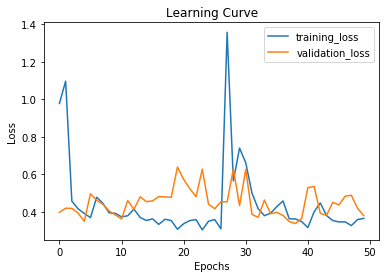

In [22]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [ ]:
#model.save("./SavedModel/my_EfficientNet_model.h5")
model.save("./saved_models/VGG16.h5")

# 用驗證集驗證與評估成效

In [23]:
y_test = [x for x in test_csv['Label']]
results = model.evaluate(test_pred, np.eye(2)[y_test])
print(f'test loss, test acc: {results}')     

20/20 [==============================] - 5s 245ms/step
test loss, test acc: [0.34070849418640137, 0.800000011920929]


In [27]:
pred = model.predict(test_pred)
pred

array([[3.63065749e-01, 6.36934161e-01],
       [2.03315303e-01, 7.96684682e-01],
       [4.89103794e-02, 9.51089680e-01],
       [2.70143896e-01, 7.29856074e-01],
       [6.86598346e-02, 9.31340158e-01],
       [2.85544723e-01, 7.14455247e-01],
       [3.13265085e-01, 6.86734915e-01],
       [1.54786035e-01, 8.45213950e-01],
       [3.90642047e-01, 6.09357953e-01],
       [1.10802926e-01, 8.89197111e-01],
       [3.25571477e-01, 6.74428523e-01],
       [1.21328130e-01, 8.78671825e-01],
       [6.33564254e-04, 9.99366462e-01],
       [3.25097255e-02, 9.67490256e-01],
       [9.28988680e-03, 9.90710080e-01],
       [4.13532518e-02, 9.58646774e-01],
       [2.15843648e-01, 7.84156322e-01],
       [2.49564294e-02, 9.75043595e-01],
       [3.70838404e-01, 6.29161596e-01],
       [2.86180645e-01, 7.13819325e-01]], dtype=float32)

In [28]:
pred = pred.argmax(-1)
print(pred)
print(y_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]


In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
print(accuracy_score(y_test, pred))                          # 觀看準確率
print(confusion_matrix(y_test, pred))                        # 可以看出實際和預測的分布
print(cohen_kappa_score(y_test, pred, weights='quadratic'))  # 衡量不平衡且類別關係為強弱對應關係的一種衡量方式

0.8
[[ 0  4]
 [ 0 16]]
0.0


In [30]:
test_csv.loc[:,"Label"] = pred
test_csv.to_csv("./outputs/sleep_apnea_VGG16_predict.csv", index=False)